In [2]:
from utils import *
from MLP import *
import copy

In [3]:
class Constants:
    """
    Recommended hyperparameters.
    Feel free to add/remove/modify these values to run your code.
    However, keep a copy of the original values as they will be used as
    reference for the local and autograder tests.

    In order to access any hyperparameter from the Constants class, just call Constants.xxx.
    """
    num_epochs = 20 # number of epochs
    num_iterate = 100 # number of iterations per epoch.
    batch_size = 100
    learning_rate = 0.00005
    n_critic = 5
    c = 0.01
    beta = 0.9 # RMSProp Parameter
    latent= 100 # latent space dimension
    discriminator_hidden_sizes = [784, 512, 256, 1]
    generator_hidden_sizes = [latent, 256, 512, 1024, 784]
    eps = 1e-8

def weights_init(inp_dim, out_dim):
    """
    Function for weights initialization
    :param inp_dim: Input dimension of the weight matrix
    :param out_dim: Output dimension of the weight matrix
    """
    b = np.sqrt(6)/np.sqrt(inp_dim+out_dim)
    return np.random.uniform(-b,b,(inp_dim,out_dim))

def biases_init(dim):
    """
    Function for biases initialization
    :param dim: Dimension of the biases vector
    """
    return np.zeros((1, dim)).astype(np.float32)

In [4]:
class Discriminator(object):
    def __init__(self):
        """
        Initialize your weights, biases and anything you need here.
        Please follow this naming convention for your variables (helpful for tests.py and autograder)
            Variable name for weight matrices: W0, W1, ...
            Variable name for biases: b0, b1, ...
        """
        
        self.dlayer = Constants.discriminator_hidden_sizes
        self.nlayer = len(self.dlayer) - 1
        self.linear_layers = [Linear(self.dlayer[i], self.dlayer[i+1], 
                                     weights_init, biases_init) for i in range(len(self.dlayer) - 1)]
        self.beta = Constants.beta
        self.lr = Constants.learning_rate
        self.c = Constants.c
        
        self.activations = [LRelu('wgan'), LRelu('wgan')]

    def forward(self, x):
        """
        Forward pass for discriminator
        :param x: Input for the forward pass with shape (batch_size, 28, 28, 1)
        :return Output of the discriminator with shape (batch_size, 1)
        NOTE: Given you are using linear layers, you will have to appropriately reshape your data.
        """
        for LayderIdx in range(self.nlayer):
            x = self.linear_layers[LayderIdx].forward(x)
            if LayderIdx != self.nlayer - 1:
                x = self.activations[LayderIdx].forward(x)
        self.output = x
        return self.output

    def backward(self, logit, image_type, update_params=True):
        """
        Backward pass for discriminator. 
        Implement RMSProp for the gradient update.
        Use/set the Learning Rate in the Constants class.

        :param logit: logit value with shape (batch_size, 1)
        :param inp: input image with shape (batch_size, 28, 28, 1). This parameter might not be required, 
        depending on your implementation.
        :image_type: Integer value -1 or 1 depending on whether it is a real or fake image.
            image_type will ensure that the gradients are taken in the rightion.
        """
        d = image_type * np.ones_like(logit)
        for LayderIdx in range(self.nlayer-1, -1, -1):
            if LayderIdx != self.nlayer-1:
                d = self.activations[LayderIdx].backward(copy.deepcopy(d))
            d = self.linear_layers[LayderIdx].backward(copy.deepcopy(d))
        return d
    
    def zero_grad(self):
        for linear in self.linear_layers:
            linear.dW.fill(0.0)
            linear.db.fill(0.0)
    
    def step(self):
        for i in range(len(self.linear_layers)):
            self.linear_layers[i].rmsprop_W = self.beta * self.linear_layers[i].rmsprop_W + (1 - self.beta) * np.square(self.linear_layers[i].dW)
            self.linear_layers[i].W += (self.lr * self.linear_layers[i].dW) / (np.sqrt(self.linear_layers[i].rmsprop_W) + Constants.eps)
            
            self.linear_layers[i].rmsprop_b = self.beta * self.linear_layers[i].rmsprop_b + (1 - self.beta) * self.linear_layers[i].db ** 2
            self.linear_layers[i].b += (self.lr * self.linear_layers[i].db) / (np.sqrt(self.linear_layers[i].rmsprop_b) + Constants.eps)                          

    def weight_clipping(self):
                                               
        """
        Implement weight clipping for discriminator's weights and biases.
        Set/use the value defined in the Constants class.
        """
        for i in range(len(self.linear_layers)):
            self.linear_layers[i].W = np.clip(self.linear_layers[i].W, - self.c, + self.c)
            self.linear_layers[i].b = np.clip(self.linear_layers[i].b, - self.c, + self.c)

    def __call__(self, x):
        """
        Do not change/remove.
        """
        return self.forward(x)

In [5]:
class Generator(object):

    def __init__(self):
        """
        Initialize your weights, biases and anything you need here.
        Please follow this naming convention for your variables (helpful for tests.py and autograder)
            Variable name for weight matrices: W0, W1, ...
            Variable name for biases: b0, b1, ...
        """
        self.dlayer = Constants.generator_hidden_sizes
        self.nlayer = len(self.dlayer) - 1
        self.linear_layers = [Linear(self.dlayer[i], self.dlayer[i+1], 
                                     weights_init, biases_init) for i in range(len(self.dlayer) - 1)]
        self.activations = [LRelu('wgan'), LRelu('wgan'), LRelu('wgan'), Tanh()]
        
        self.beta = Constants.beta
        self.lr = Constants.learning_rate

    def forward(self, z):
        """
        Forward pass for generator
        :param z: Input for the forward pass with shape (batch_size, 100)
                 Output of the final linear layer will be of shape (batch_size, 784)
        :return Output of the generator with shape (batch_size, 28, 28, 1)
        """
        for LayderIdx in range(self.nlayer):
            z = self.linear_layers[LayderIdx].forward(z)
            z = self.activations[LayderIdx].forward(z)      
        self.output = z
        return self.output

    def backward(self, fake_logit, discriminator):
        """
        Backward pass for generator
        Implement RMSProp for the gradient update.
        Use/set the Learning Rate in the Constants class.

        :param fake_logit: Logit output from the discriminator with shape (batch_size, 1)
        :param fake_input: Fake images generated by the generator with shape (batch_size, 28, 28, 1) 
            -- may or may not be required depending upon your implementation.
        :param discriminator: discriminator object
        NOTE: In order to perform backward, you may or may not (based on your 
        implementation) need to call the backward function in the discriminator.
              In such an event, make sure that the Discriminator weights are *not* 
              being updated for this particular call.
        """
        d = discriminator.backward(fake_logit, 1)
        for LayderIdx in range(self.nlayer-1, -1, -1):
            d = self.activations[LayderIdx].backward(d)
            d = self.linear_layers[LayderIdx].backward(copy.deepcopy(d))
        return d
    
    def zero_grad(self):
        for linear in self.linear_layers:
            linear.dW.fill(0.0)
            linear.db.fill(0.0)
    
    def step(self):
        for i in range(len(self.linear_layers)):
            self.linear_layers[i].rmsprop_W = (self.beta * self.linear_layers[i].rmsprop_W + 
                                               (1 - self.beta) * self.linear_layers[i].dW ** 2)
            self.linear_layers[i].W += (self.lr * self.linear_layers[i].dW / 
                                        (np.sqrt(self.linear_layers[i].rmsprop_W) + Constants.eps))
            
            self.linear_layers[i].rmsprop_b = (self.beta * self.linear_layers[i].rmsprop_b + 
                                               (1 - self.beta) * self.linear_layers[i].db ** 2)
            self.linear_layers[i].b += (self.lr * self.linear_layers[i].db / 
                                        (np.sqrt(self.linear_layers[i].rmsprop_b) + Constants.eps))  
    
    def __call__(self, z):
        """
        Do not change/remove.
        """
        return self.forward(z)

In [12]:
class WGAN(object):

    def __init__(self, generator, discriminator):
        """
        Initialize the GAN with your discriminator, generator and anything you need here.
        Feel free to change/modify your function signatures here, this will *not* be autograded.
        """
        self.generator = generator
        self.discriminator = discriminator
        self.n_critic = Constants.n_critic
        self.batch_size = Constants.batch_size
        self.seed = 19980709

    def linear_interpolation(self):
        """
        Generate linear interpolation between two data points. 
        (See example on Lec15 slides page 29
        and feel free to modify the function signature. This function is not graded by autograder.)
        """
        raise NotImplementedError

    def train_one_batch(self, train_X):
        """
        Determine how to train the WGAN. 
        You can use the "img_tile" functions in utils.py to visualize your generated batch.

        If you make changes to the vizualization procedure for the fake batches, 
        please include them in your utils.py file.
        """
        for i in range(self.n_critic):
            idx = np.random.choice(np.arange(len(train_X)), self.batch_size, replace=True)
            batch_real = train_X[idx]
            batch_noise = np.random.randn(self.batch_size, 100)
            batch_fake = self.generator(batch_noise)
            
            self.discriminator.zero_grad()
            
            score_real = self.discriminator(batch_real)
            self.discriminator.backward(score_real, 1)
            score_fake = self.discriminator(batch_fake)
            self.discriminator.backward(score_fake, -1)
            
            self.discriminator.step()
            self.discriminator.weight_clipping()
        
        batch_noise = np.random.randn(self.batch_size, 100)
        batch_fake = self.generator(batch_noise)
        
        self.generator.zero_grad()
        fake_score = self.discriminator(batch_fake)
        self.generator.backward(fake_score, self.discriminator)
        self.generator.step()
    
    def generate(self, batch_size):
        
        batch_noise = np.random.randn(batch_size, 100)
        batch_fake = self.generator(batch_noise)
        return batch_fake.reshape(28, 28, batch_size)

----- epoch0 -----


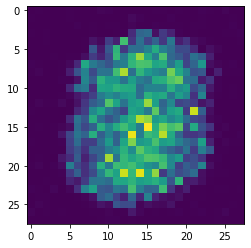

In [14]:
if __name__ == '__main__':
    """
    You can implement your training and testing loop here.
    You MUST use your class implementations to train the model and to get the results.
    DO NOT use pytorch or tensorflow get the results. The results generated using these
    libraries will be different as compared to your implementation.
    """
    train_X, _, _ = mnist_reader([i for i in range(10)])
    np.random.shuffle(train_X)
    
    model = WGAN(Generator(), Discriminator())
    for ep in range(1): #Constants.num_epochs
        print('----- epoch{} -----'.format(ep))
        for it in range(Constants.num_iterate):
            model.train_one_batch(train_X.reshape(train_X.shape[0], -1))
        result = model.generate(1)
        plt.imshow(result)
        plt.show()
        # img_tile(result, './gen_img/', ep, 1, aspect_ratio=1.0, border=1, border_color=0)